<a href="https://colab.research.google.com/github/Seowoo-Jung/ESAA/blob/main/3_%EB%B6%84%EB%A5%98_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 분류

## 3.1 MNIST

In [2]:
# 데이터 불러오기
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape) # data 키: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열
print(y.shape) # target 키: 레이블 배열

(70000, 784)
(70000,)


- 이미지가 70000개 있고 784개의 특성이 있다. (픽셀이 28*28)
- 흰색(0) 부터 검은색(255) 까지의 픽셀 강도를 나타냄.


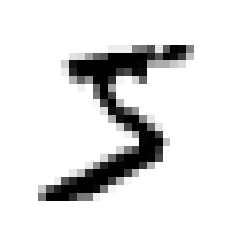

In [4]:
# 이미지 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) # 크기를 28*28으로 나눠줌

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# 실제 레이블 
y[0]

'5'

In [7]:
import numpy as np
y=y.astype(np.uint8) # 대부분 숫자이므로 target 값을 정수로 변환

In [9]:
# test 와 train split: 이미 데이터 자체가 섞여있으므로 앞에서부터 60000개 단위로 추출함.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기

: 특정숫자 맞음, 특정숫자 아님 (2개의 클래스를 구분함)

In [11]:
y_train_5 = (y_train == 5) # 5가 맞으면 T 아니면 F
y_test_5 = (y_test == 5)

- SGD 분류기

: 매우 큰 데이터셋을 효율적으로 처리함.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42) # 훈련시 무작위성을 사용하므로 random_state를 지정한다.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
# 성능측정
sgd_clf.predict([some_digit]) # some_digit이 5라고 추측

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정



In [16]:
## 교차 검증 직접 구현: 사이킷런이 제공하는 것 보다 더 많이 교차검증하고싶을 때 (다시)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf) #
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # ryckrjawmd

array([0.95035, 0.96035, 0.9604 ])

In [22]:
## 모든 이미지를 5가 아님으로 예측하는 분류하는 분류기를 만들고 성능예측
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool) # 5아님 :0

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 데이터셋의 90%정도가 5이기 때문에 정확히 맞출 확률이 높음.
- 불균형한 데이터 셋을 다룰 때,정확도를 분류기의 성능으로 잘 사용하지 않는다.

### 3.3.2 오차 행렬

In [24]:
# 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # 각 테스트 폴드에서 얻은 예측값을 반환

In [26]:
## 오차행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) ## 왜 다르게 나와...?
# [1,1], [2,2]가 정확하게 맞춘 경우

array([[53892,   687],
       [ 1891,  3530]])

In [27]:
## 완벽한 분류기인 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

정밀도 (양성 예측의 정확도)=TP/(TP+FP) 
: 양성으로 예측한것들 중에 진짜 양성인 비율

재현율 (분류기가 정확하게 감지한 양성샘플의 비율) =  TP / (TP +FN)

:진짜 양성인것들 중에 양성으로 예측한 비율

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 정밀도

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred) # 재현율

0.6511713705958311

정밀도와 재현율을 하나로 평가하는거 : F1 점수 > 조화평균

- 정밀도와 재현율이 비슷하다면 f1점수가 좋은데 둘중 하나만 좋다면 그렇지 않다.

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

- 임계값을 높이면 정밀도가 올라가고 재현율이 내려감. 임계값을 내리면 재현율이 높아지고 정밀도가 줄어듦.

In [33]:
# 점수를 기반으로 임곗값을 정해 예측하자
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [36]:
threshold=0
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold=8000
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred # 임계값 높이면 재현율이 줄어듦.

array([False])

In [38]:
# 적절한 임계값 찾기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [39]:
## 모든 임계값에 대한 그래프
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

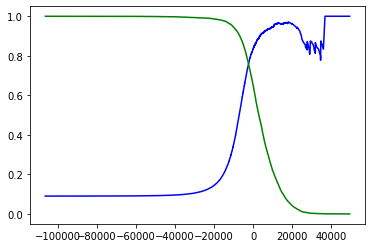

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b-", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 하강 직전의 임계값을 선택

In [42]:
threshold_90_precision= thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293


0.4799852425751706

### 3.3.5 ROC 곡선

- 1-특이도에 대한 그래프

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

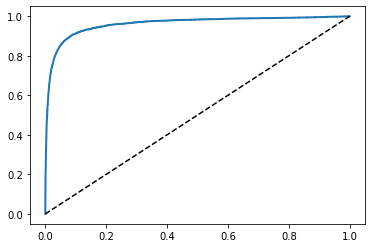

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

- ROC 면적이 넓어야함

In [49]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [50]:
## RandomForestClassifier와 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [51]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

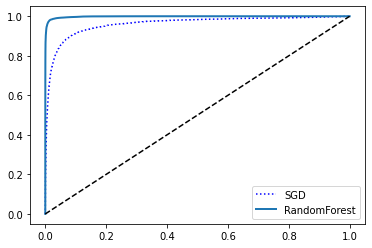

In [53]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

- Random Forest 기법이 더 좋음.